In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [9]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = 10


In [10]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [11]:
def get_alexnet():
    model = models.alexnet(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model


In [12]:
def get_vgg():
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model


In [13]:
def get_resnet():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [14]:
def get_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [30]:
def get_inception():
    model = models.inception_v3(
        pretrained=True,
        aux_logits=True   # IMPORTANT
    )

    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifiers
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    return model


In [16]:
def get_mobilenet():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()


In [18]:
class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        cosine = F.normalize(logits)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1)
        output = self.s * (cosine - one_hot * self.m)
        return F.cross_entropy(output, labels)


In [19]:
def train(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {100*correct/total:.2f}%")

def test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return 100 * correct / total


In [20]:
model = get_vgg().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, 10)
vgg_acc = test(model, test_loader)
print("VGG Test Accuracy:", vgg_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Acc: 80.10%
Epoch 2/10 | Train Acc: 90.22%
Epoch 3/10 | Train Acc: 94.91%
Epoch 4/10 | Train Acc: 97.24%
Epoch 5/10 | Train Acc: 98.02%
Epoch 6/10 | Train Acc: 98.24%
Epoch 7/10 | Train Acc: 98.52%
Epoch 8/10 | Train Acc: 98.66%
Epoch 9/10 | Train Acc: 98.86%
Epoch 10/10 | Train Acc: 98.90%
VGG Test Accuracy: 85.99


In [21]:
model = get_alexnet().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = FocalLoss()

train(model, train_loader, optimizer, criterion, 20)
alex_acc = test(model, test_loader)
print("AlexNet Test Accuracy:", alex_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train Acc: 68.45%
Epoch 2/20 | Train Acc: 75.31%
Epoch 3/20 | Train Acc: 77.36%
Epoch 4/20 | Train Acc: 78.87%
Epoch 5/20 | Train Acc: 79.72%
Epoch 6/20 | Train Acc: 80.75%
Epoch 7/20 | Train Acc: 81.51%
Epoch 8/20 | Train Acc: 82.16%
Epoch 9/20 | Train Acc: 82.87%
Epoch 10/20 | Train Acc: 83.24%
Epoch 11/20 | Train Acc: 83.81%
Epoch 12/20 | Train Acc: 84.35%
Epoch 13/20 | Train Acc: 84.63%
Epoch 14/20 | Train Acc: 85.28%
Epoch 15/20 | Train Acc: 85.64%
Epoch 16/20 | Train Acc: 86.07%
Epoch 17/20 | Train Acc: 86.29%
Epoch 18/20 | Train Acc: 86.75%
Epoch 19/20 | Train Acc: 87.17%
Epoch 20/20 | Train Acc: 87.29%
AlexNet Test Accuracy: 85.22


In [22]:
model = get_resnet().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = ArcFaceLoss()

train(model, train_loader, optimizer, criterion, 15)
resnet_acc = test(model, test_loader)
print("ResNet Test Accuracy:", resnet_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Epoch 1/15 | Train Acc: 65.43%
Epoch 2/15 | Train Acc: 77.85%
Epoch 3/15 | Train Acc: 78.80%
Epoch 4/15 | Train Acc: 79.58%
Epoch 5/15 | Train Acc: 80.14%
Epoch 6/15 | Train Acc: 80.69%
Epoch 7/15 | Train Acc: 80.90%
Epoch 8/15 | Train Acc: 81.51%
Epoch 9/15 | Train Acc: 81.75%
Epoch 10/15 | Train Acc: 81.77%
Epoch 11/15 | Train Acc: 81.97%
Epoch 12/15 | Train Acc: 82.24%
Epoch 13/15 | Train Acc: 82.27%
Epoch 14/15 | Train Acc: 82.59%
Epoch 15/15 | Train Acc: 82.84%
ResNet Test Accuracy: 82.03


In [23]:
print("MODEL\t\tLOSS\t\tTEST ACC")
print(f"VGG\t\tBCE\t\t{vgg_acc:.2f}")
print(f"AlexNet\t\tFocal\t\t{alex_acc:.2f}")
print(f"ResNet\t\tArcFace\t\t{resnet_acc:.2f}")


MODEL		LOSS		TEST ACC
VGG		BCE		85.99
AlexNet		Focal		85.22
ResNet		ArcFace		82.03


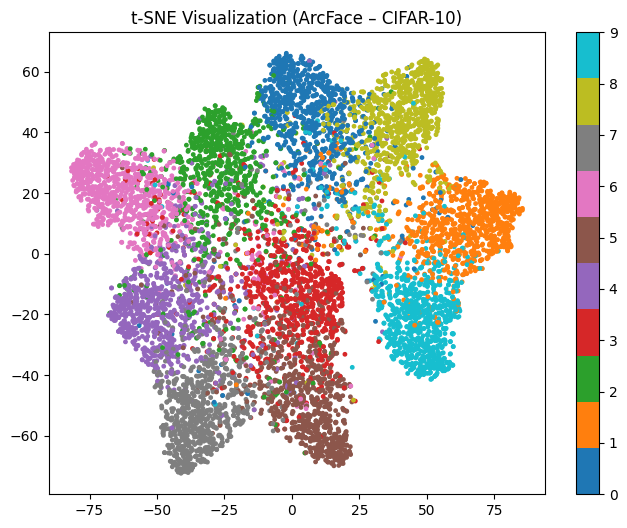

In [24]:
def extract_features(model, loader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            feats.append(out.cpu())
            labels.append(y)
    return torch.cat(feats), torch.cat(labels)

features, labels = extract_features(model, test_loader)

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(features.numpy())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=6)
plt.title("t-SNE Visualization (ArcFace – CIFAR-10)")
plt.colorbar()
plt.show()


In [26]:
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, epochs=3)
lenet_acc = test(model, test_loader)
print("LeNet-5 Test Accuracy:", lenet_acc)


Epoch 1/3 | Train Acc: 43.72%
Epoch 2/3 | Train Acc: 55.36%
Epoch 3/3 | Train Acc: 61.33%
LeNet-5 Test Accuracy: 56.34


In [27]:
model = get_efficientnet().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, epochs=3)
eff_acc = test(model, test_loader)
print("EfficientNet Test Accuracy:", eff_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


Epoch 1/3 | Train Acc: 58.86%
Epoch 2/3 | Train Acc: 71.04%
Epoch 3/3 | Train Acc: 72.90%
EfficientNet Test Accuracy: 76.78


In [28]:
inception_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_inc = datasets.CIFAR10(root='./data', train=True, download=False, transform=inception_transform)
test_inc  = datasets.CIFAR10(root='./data', train=False, download=False, transform=inception_transform)

train_inc_loader = DataLoader(train_inc, batch_size=32, shuffle=True)
test_inc_loader  = DataLoader(test_inc, batch_size=32, shuffle=False)


In [31]:
def train_inception(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs, aux_outputs = model(x)

            loss1 = criterion(outputs, y)
            loss2 = criterion(aux_outputs, y)
            loss = loss1 + 0.4 * loss2

            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {100*correct/total:.2f}%")


In [32]:
def test_inception(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)  # only main output
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)
    return 100 * correct / total


In [33]:
model = get_inception().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_inception(model, train_inc_loader, optimizer, criterion, epochs=3)
inc_acc = test_inception(model, test_inc_loader)

print("InceptionV3 Test Accuracy:", inc_acc)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 129MB/s] 


Epoch 1/3 | Train Acc: 55.86%
Epoch 2/3 | Train Acc: 67.22%
Epoch 3/3 | Train Acc: 68.48%
InceptionV3 Test Accuracy: 73.01


In [34]:
model = get_mobilenet().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, epochs=3)
mobile_acc = test(model, test_loader)
print("MobileNetV2 Test Accuracy:", mobile_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


Epoch 1/3 | Train Acc: 57.96%
Epoch 2/3 | Train Acc: 71.04%
Epoch 3/3 | Train Acc: 72.98%
MobileNetV2 Test Accuracy: 75.54


In [35]:
model = models.resnet101(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, epochs=3)
resnet101_acc = test(model, test_loader)
print("ResNet-101 Test Accuracy:", resnet101_acc)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 197MB/s]


Epoch 1/3 | Train Acc: 71.04%
Epoch 2/3 | Train Acc: 79.83%
Epoch 3/3 | Train Acc: 81.30%
ResNet-101 Test Accuracy: 81.8


In [36]:
print("\nMODEL\t\tTEST ACCURACY")
print(f"LeNet-5\t\t{lenet_acc:.2f}")
print(f"AlexNet\t\t{alex_acc:.2f}")
print(f"VGG16\t\t{vgg_acc:.2f}")
print(f"ResNet-50\t{resnet_acc:.2f}")
print(f"EfficientNet\t{eff_acc:.2f}")
print(f"InceptionV3\t{inc_acc:.2f}")
print(f"MobileNetV2\t{mobile_acc:.2f}")



MODEL		TEST ACCURACY
LeNet-5		56.34
AlexNet		85.22
VGG16		85.99
ResNet-50	82.03
EfficientNet	76.78
InceptionV3	73.01
MobileNetV2	75.54
